# Introduction to Data Science - Homework 8
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, March 16, 11:59pm.

In this homework, you will use clustering, regular expressions, and natural language processing. 

## Your Data
First Name: Brooke
<br>
Last Name: Stanislawski
<br>
E-mail: brooke.stanislawski@utah.edu
<br>
UID: u1142223
<br>

In [30]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])

## Part 1: Analyze US Crime data

We'll analyze a dataset describing 1973 violent crime rates by US State. The crimes considered are assault, murder, and rape. Also included is the percent of the population living in urban areas.

The dataset is available as *USarrests.csv*. The dataset has 50 observations (corresponding to each state) on 4 variables: 
1. Murder: Murder arrests (per 100,000 residents)
2. Assault: Assault arrests (per 100,000 residents)
3. UrbanPop: Percent urban population
4. Rape: Rape arrests (per 100,000 residents)


You can read more about the dataset [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html). 

Our goal will be to use clustering tools to understand how violent crimes differ between states. 


### Task 1.1 Import the data and perform some prelimary exploratory analysis. 
Use the *read_csv* pandas function to import the data as a dataframe. 

Plot a scatterplot matrix of the data. Explore basic statistics of the data. Write a few sentences describing how the variables are correlated. 

In [2]:
# Your code here
crimedf = pd.read_csv('USarrests.csv')
crimedf.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
crimedf.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [4]:
crimedf.dtypes

Unnamed: 0     object
Murder        float64
Assault         int64
UrbanPop        int64
Rape          float64
dtype: object

In [5]:
crime_corr = crimedf.corr()
crime_corr

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


Text(0.5,1,'Heat Map of Coefficients')

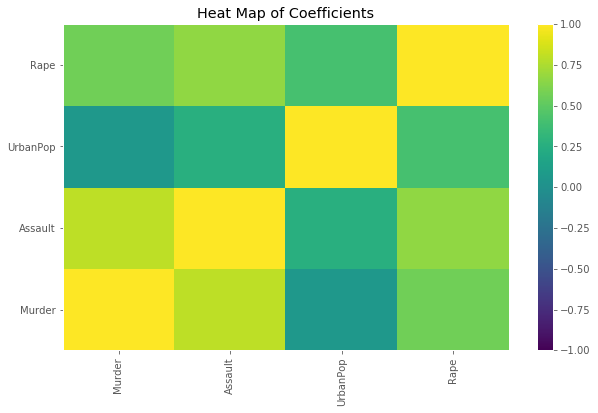

In [6]:
ind = np.arange(len(list(crime_corr))) + 0.5
labels = list(crime_corr)[1:]
plt.pcolor(crime_corr,vmin=-1,vmax=1)
plt.xticks(ind,list(crime_corr),rotation=90)
plt.yticks(ind,list(crime_corr))
plt.colorbar()
plt.title('Heat Map of Coefficients')

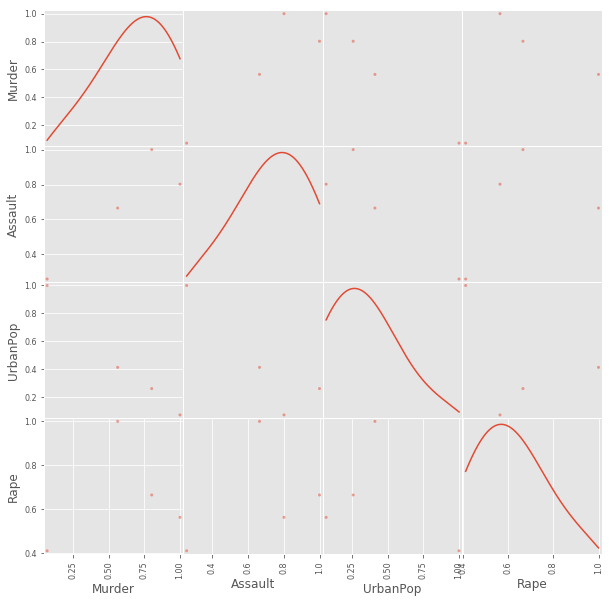

In [7]:
pd.plotting.scatter_matrix(crime_corr, figsize=(10, 10), diagonal='kde')
plt.show()

**Your description:** TODO 

### Task 1.2 k-means cluster analysis
1. Scale the dataset using the *scale* function of the sklearn.preprocessing library. 
+ Using k-means, cluster the states into four clusters. Which states belong to which clusters?
+ Vary k and find the *best* value. How do you determine *best*? 

mean check: [ -7.10542736e-17   1.38777878e-16  -4.39648318e-16   8.59312621e-16]
std dev check: [ 1.  1.  1.  1.]


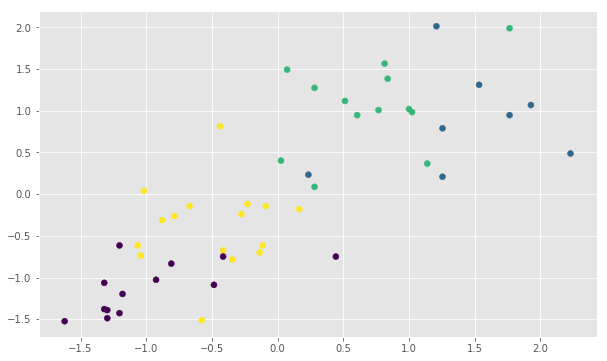

In [25]:
# Your code here
scaledX = scale(crimedf[['Murder','Assault','UrbanPop','Rape']])
#check
print('mean check:',scaledX.mean(axis=0))
print('std dev check:',scaledX.std(axis=0))

data_pred = KMeans(n_clusters=4,).fit_predict(scaledX)
plt.scatter(scaledX[:, 0], scaledX[:, 1], c=data_pred,  marker="o") 

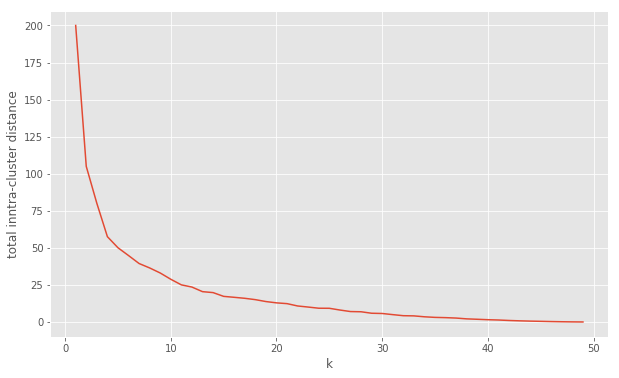

In [26]:
#%% determining best k: measuring intra-cluster distances

# clustering for k = 1 to k = 10
ks = range(1,50)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(scaledX)
    scores.append(-model.score(scaledX))

plt.plot(ks, scores)
plt.ylabel('total inntra-cluster distance')
plt.xlabel('k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.408489032622


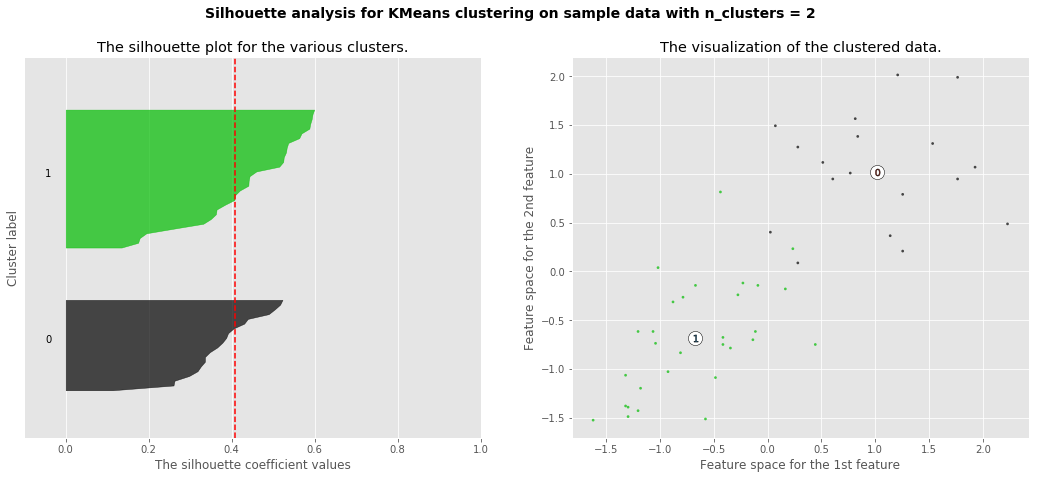

For n_clusters = 3 The average silhouette_score is : 0.308136226489


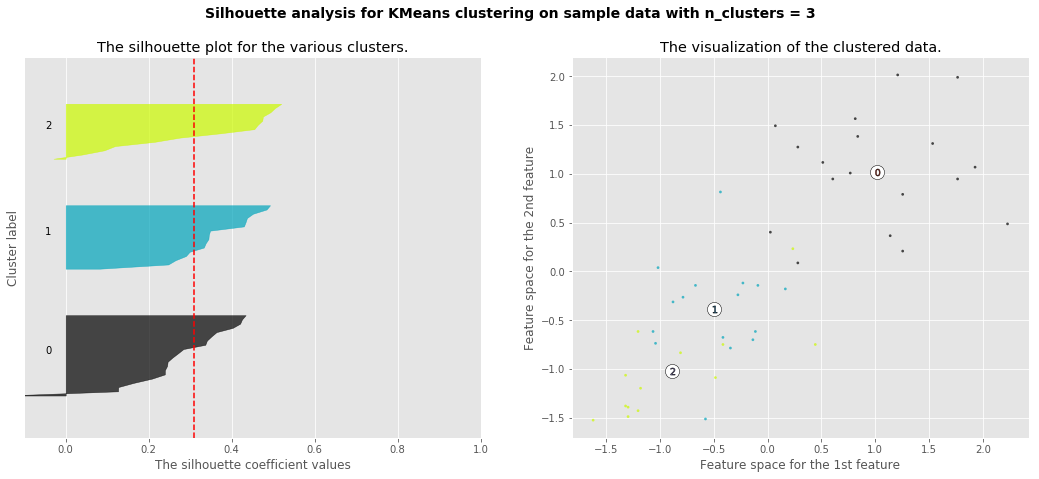

For n_clusters = 4 The average silhouette_score is : 0.339688914333


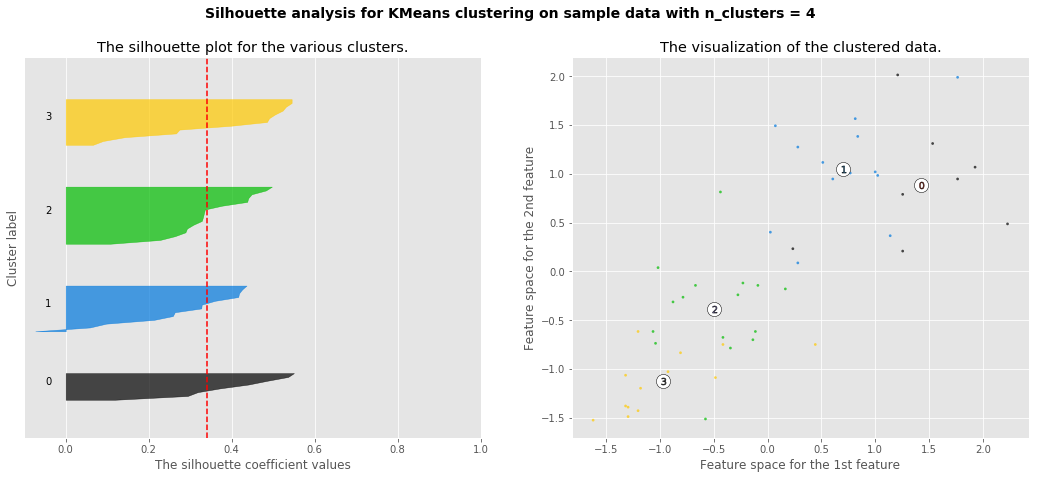

For n_clusters = 5 The average silhouette_score is : 0.313354432693


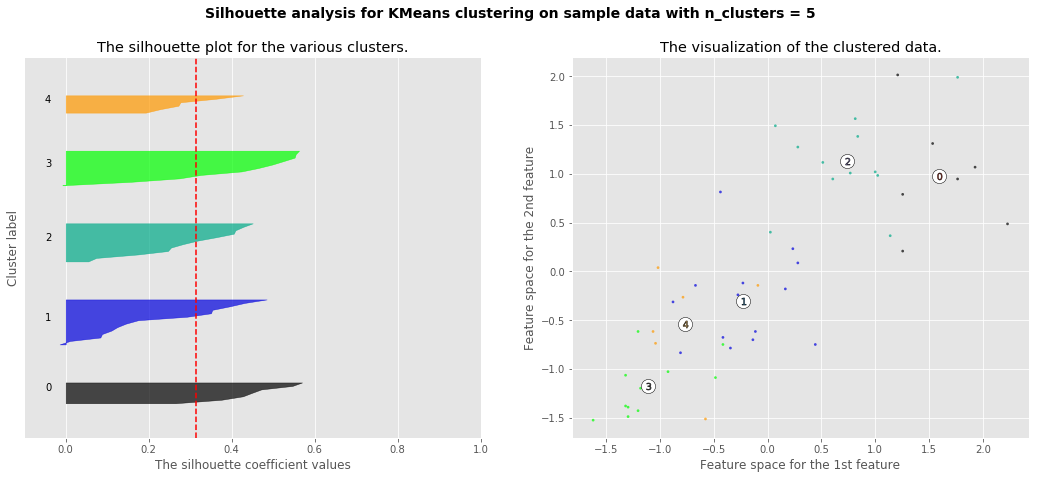

For n_clusters = 6 The average silhouette_score is : 0.296752128024


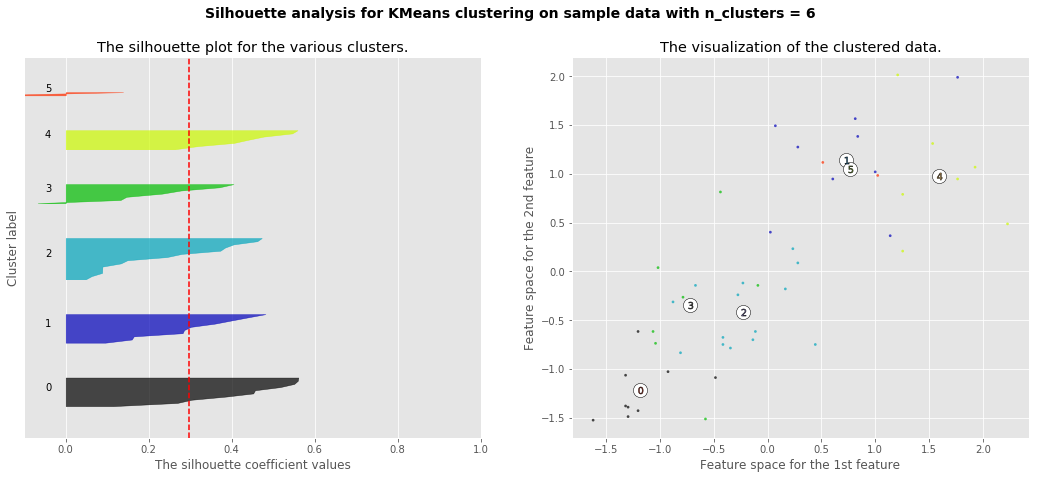

In [31]:
#%% determining best k: silhouette analysis

range_n_clusters = [2, 3, 4, 5, 6]


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaledX) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaledX)

    silhouette_avg = silhouette_score(scaledX, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaledX, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
#    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(scaledX[:, 0], scaledX[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
# so best n_clusters = 2?
# For n_clusters = 2 The average silhouette_score is : 0.408489032622

**Interpretation:** TODO

### Task 1.3 Hierarchical cluster analysis

1.  Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states into four clusters. Which states belong to which clusters? 
2. Do you get similiar results as for k-means? 

In [ ]:
# Your code here


**Interpretation:** TODO

# 2. Regular Expressions 

Write regular expressions for the following examples that matches the data of the given format and any other reasonable variations thereof. E.g., your regex shouldn't be specific to one URL or one phone number, but should work for all examples of the same format.

**2.1.** Writes a regular expression that extracts the urls out of this string, but only the URLs.

In [10]:
text = """To learn about pros/cons of data science, go to http://datascience.net.\
Alternatively, go to datascience.net/2018/"""

In [24]:
# your solution
url = 'Visit the course website <a href="http://datasciencecourse.net">here</a>'
# legal characters in a url are \w, :, slash / which we have to escape to \/, period ., 
# which we have to escape to \.
match = re.search(r'([\w+\.]+)', text)
#match = re.search(r'href="([\w:/\.]+)"', url)
print('The whole match:',match)

The whole match: <_sre.SRE_Match object; span=(0, 2), match='To'>


**2.2.** Write a regular expression that extracts all phone numbers and fax numbers from this text: 

In [ ]:
text = """You can reach me at 801-774-4321, or my office at (801) 223 9571.\ 
Send me a fax at 857 188 7422. We finally made the sale for all 977 giraffes.\
They wanted 225 957 dollars for it."""

In [ ]:
# your solution

**2.3.** Write a regular expression that extracts all opening html tags from this, including `<br />`.

In [ ]:
html = "This is <b>important</b> and <u>very</u><i>timely</i><br />. Was this <span> what you meant?</span>"

In [ ]:
# your solution

**2.4.** Write a regular expression that extracts all the names of people from the following text. 

In [ ]:
text = """Arnold Schwarzenegger was born in Austria. He and Sylvester Stalone used to run a restaurant\
with J. Edgar Hoover."""

In [ ]:
# your solution

**2.5.** Write a regular expression that extracts the text out of all html elements of class important.

In [ ]:
text = """Lorem ipsum dolor <b>sit</b> amet, <b class="important">consectetur adipiscing</b> elit,\ 
sed do eiusmod <span id="note">tempor incididunt ut</span> <div>labore <strong class="important">\
et dolore magna</strong> aliqua.</div> Ut enim ad minim veniam, quis nostrud exercitation ullamco."""

In [ ]:
# your solution

## 3. NLP: Classifying Newsgroups Articles

Newsgroups were the social media of the 90s. Newsgroups are open discussion forums structured into hierarchices. For example, the following newsgroups cover topics as divers as atheism, computer graphics, and classified ads.  

```
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
```

We will be combining machine learning and natural language processing to classify the news articles into these groups. We expect, for example, that the text for a classified ad in `misc.forsale` is different from text in `alt.atheism`. 

We will use the 20 Newsgroups corpus from scikit-learn. The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. The general steps we follow are:
1. Load the corpus    
+ Do preprocessing: removal of stopwords, stemming, etc.
+ Vectorize the text
+ Split into training and test sets
+ Train our classifier

Refer to documentation on the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) to learn about the dataset and find out how to download it.
We recommended you use the `subset='all'` parameter to load all the data at once, instead of `subset='train'` and `subset='test'` seperately.

**3.1.** Load the dataset.

1. Print the exact number of news articles in the corpus.
2. Print all 20 categories the news articles belong to.

In [ ]:
# your solution

### 3.2 Classification

Vectorize the data using vectorizers from sklearn. Using these vectors as features and the article category from corpus as labels, train a NaiveBayes classifer to classify the data.

#### Vectorizers

Vectorizes help us to transform text data into features we can use in machine learning. We did the vectorization manually in class, here you will use pre-build vectorizers. 

You should use CountVectorizer and TfidfVectorizer vectorizers from sklearn to vectorize your data. Please refer to documentation on both to learn how to use them.
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Compare the performance of classifiers using both vectorizers. You are encouraged to experiment with different parameters like max_df, min_df, etc. See docs for the meanings.

#### Naive Bayes
**Resources**
1. https://en.wikipedia.org/wiki/Naive_Bayes_classifier
2. https://www.geeksforgeeks.org/naive-bayes-classifiers
3. http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will be using Multinomial Naive Bayes from sklearn. Refer to documentation above for how to import the classifer. Then it can be used like any other classifer by using fit and predict functions provided on it.
e.g:

```
clf = MulitnomialNB(alpha = 1)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
```

Alpha is also known as the smoothing factor and ranges from 0 (no smoothing) to 1 (Laplace Smoothing). You can experiment with different values to see if you get better results. 


In [ ]:
# your solution

#### Removing Stopwords

Now we'll use the NLTK stopword list to improve our data vectors. TfidfVectorizer and CountVectorizer both can take an argument called stop_words. The words passed to this arguement are considered as stopwords and are not vectorized. Use the stopwords list from NLTK and pass it to vectorizers. Then evalulate the new vectors using Multinomial Naive Bayes.

In [ ]:
# your solution

#### Interpretation

1. How much accuracy would a naive approach, that picks one of the 20 categories at random achieve?
1. What accuracy where you able to achieve? 
1. What was the influence of the different vectorizers and the stopword removal? 


**Your Reponses:** TODO